In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download necessary NLTK data
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pande\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
import yfinance as yf
import talib
import numpy as np

def get_stock_data(ticker):
    # Fetch all available historical data
    data = yf.download(ticker, progress=False)
    
    # Ensure the Close column is a 1D array before passing to TA-Lib
    close_prices = data['Close'].astype(float).values.flatten()

    data['RSI'] = talib.RSI(close_prices, timeperiod=14)
    data['MA_10'] = talib.SMA(close_prices, timeperiod=10)
    data['MA_30'] = talib.SMA(close_prices, timeperiod=30)
    data['MA_50'] = talib.SMA(close_prices, timeperiod=50)
    data['MA_200'] = talib.SMA(close_prices, timeperiod=200)

    upper, middle, lower = talib.BBANDS(close_prices, timeperiod=20)
    data['Upper_Band'] = upper
    data['Lower_Band'] = lower

    data.dropna(inplace=True)
    return data

# Example Usage
df = get_stock_data("TCS.NS")  # Replace with your stock ticker
df.head()  # Display the first few rows


Price,Close,High,Low,Open,Volume,RSI,MA_10,MA_30,MA_50,MA_200,Upper_Band,Lower_Band
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS,,,,,,,
Date,,,,,,,,,,,,
2003-05-19,27.760582,27.760582,27.760582,27.760582,0,26.580776,27.760582,27.760582,28.443072,31.402636,27.760582,27.760582
2003-05-20,27.760582,27.760582,27.760582,27.760582,0,26.580776,27.760582,27.760582,28.404925,31.397890,27.760582,27.760582
2003-05-21,27.760582,27.760582,27.760582,27.760582,0,26.580776,27.760582,27.760582,28.352495,31.395088,27.760582,27.760582
2003-05-22,27.760582,27.760582,27.760582,27.760582,0,26.580776,27.760582,27.760582,28.309105,31.402049,27.760582,27.760582
2003-05-23,27.760582,27.760582,27.760582,27.760582,0,26.580776,27.760582,27.760582,28.257940,31.409009,27.760582,27.760582


In [9]:
def preprocess_lstm_data(df, columns=['Close'], time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[columns])
    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

# Build LSTM Model with Optimizations
def build_stacked_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [10]:
def train_lstm_model(X_train, y_train, model_name,epoch):
    model = build_stacked_lstm_model((X_train.shape[1], X_train.shape[2]))
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=3.1250e-05, verbose=1)
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=1, callbacks=[lr_scheduler])
    model.save(f"{model_name}.h5")
    return model

# Sentiment Analysis
def get_sentiment_score(text):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)['compound']
    return score

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_ensemble(ticker, forecast_days=30, epoch=50):
    df = get_stock_data(ticker)
    time_step = 60
    
    # Ensure the correct columns are selected for feature engineering
    feature_columns = ['Close', 'RSI', 'MA_10', 'MA_30', 'MA_50', 'MA_200', 'Upper_Band', 'Lower_Band']
    
    # Preprocess data
    X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
    X_train, y_train = X[:-forecast_days], y[:-forecast_days]
    X_test = X[-forecast_days:]

    try:
        model = load_model(f"{ticker}_model.h5")
    except:
        model = train_lstm_model(X_train, y_train, ticker, epoch)

    predictions = model.predict(X_test)

    # Create an empty array for inverse transform with correct shape
    dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))  # (30, 8)
    dummy_array[:, 0] = predictions[:, 0]  # Fill only the Close column

    # Inverse transform using the full shape
    predictions = scaler.inverse_transform(dummy_array)[:, 0]  # Extract only the Close column

    # Inverse transform actual y values
    y_actual = np.zeros((y[-forecast_days:].shape[0], len(feature_columns)))
    y_actual[:, 0] = y[-forecast_days:]  # Fill only the Close column
    y_actual = scaler.inverse_transform(y_actual)[:, 0]  # Extract only Close column

    # Sentiment Adjustment
    headline = f"{ticker} stock market update"
    sentiment_score = get_sentiment_score(headline)
    sentiment_adjustment = 1 + (sentiment_score * 0.03)
    adjusted_preds = predictions * sentiment_adjustment

    # Calculate Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(y_actual, adjusted_preds))
    mae = mean_absolute_error(y_actual, adjusted_preds)
    mape = np.mean(np.abs((y_actual - adjusted_preds) / y_actual)) * 100
    r2 = r2_score(y_actual, adjusted_preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MAPE:", mape)
    print("R^2 Score:", r2)

    # Plot Results
    last_dates = df.index[-forecast_days:]
    plt.figure(figsize=(12, 6))
    plt.plot(last_dates, y_actual, label='Actual')
    plt.plot(last_dates, predictions, label='LSTM Forecast')
    plt.plot(last_dates, adjusted_preds, label='Ensemble Forecast (Sentiment)', linestyle='--')
    plt.title(f"{ticker} - Enhanced Ensemble Forecast ({forecast_days} days), {epoch} Epochs")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_multiple_indices(tickers, forecast_days=30, epoch=50):
    plt.figure(figsize=(12, 6))

    for ticker in tickers:
        df = get_stock_data(ticker)

        # Check if data is empty
        if df.empty:
            print(f"⚠️ Warning: No data found for {ticker}. Skipping...")
            continue

        time_step = 60
        feature_columns = ['Close', 'RSI', 'MA_10', 'MA_30', 'MA_50', 'MA_200', 'Upper_Band', 'Lower_Band']

        # Preprocess Data
        try:
            X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
        except ValueError as e:
            print(f"⚠️ Error processing {ticker}: {e}")
            continue  # Skip this index

        if len(X) == 0 or len(y) == 0:
            print(f"⚠️ Warning: Insufficient data for {ticker}. Skipping...")
            continue

        X_train, y_train = X[:-forecast_days], y[:-forecast_days]
        X_test, y_test = X[-forecast_days:], y[-forecast_days:]

        try:
            model = load_model(f"{ticker}_model.h5")
        except:
            model = train_lstm_model(X_train, y_train, ticker, epoch)

        # Make Predictions
        predictions = model.predict(X_test)
        dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))
        dummy_array[:, 0] = predictions[:, 0]
        predictions = scaler.inverse_transform(dummy_array)[:, 0]

        # Inverse transform actual y values
        y_actual = np.zeros((y_test.shape[0], len(feature_columns)))
        y_actual[:, 0] = y_test
        y_actual = scaler.inverse_transform(y_actual)[:, 0]

        # Compute Metrics
        rmse = np.sqrt(mean_squared_error(y_actual, predictions))
        mae = mean_absolute_error(y_actual, predictions)
        mape = np.mean(np.abs((y_actual - predictions) / y_actual)) * 100
        r2 = r2_score(y_actual, predictions)

        print(f"📊 Performance Metrics for {ticker}:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R² Score: {r2:.4f}\n")

        # Sentiment Adjustment
        headline = f"{ticker} stock market update"
        sentiment_score = get_sentiment_score(headline)
        sentiment_adjustment = 1 + (sentiment_score * 0.03)
        adjusted_preds = predictions * sentiment_adjustment

        # Plot Results for each Index
        last_dates = df.index[-forecast_days:]
        plt.plot(last_dates, adjusted_preds, label=f"{ticker} Forecast")
        plt.plot(last_dates, y_actual, linestyle="dashed", label=f"{ticker} Actual")

    plt.title(f"Stock Market Forecast vs Actual Data ({forecast_days} days)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
forecast_ensemble("TCS.NS",epoch=50)
forecast_ensemble("TCS.NS",epoch=100)
forecast_ensemble("TCS.NS",epoch=150)
forecast_ensemble("TCS.NS",epoch=200)
forecast_ensemble("TCS.NS",epoch=250)

Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - loss: 0.0399 - learning_rate: 0.0010
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 9.1987e-04 - learning_rate: 0.0010
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 7.3489e-04 - learning_rate: 0.0010
Epoch 9/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - loss: 6.4677e-04 - learning_rate: 0.0010
Epoch 10/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - loss: 6.1010e-04 - learning_rate: 0.0010
Epoch 11/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - loss: 

Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - loss: 0.0324 - learning_rate: 0.0010
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 9.0912e-04 - learning_rate: 0.0010
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 7.8878e-04 - learning_rate: 0.0010
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 8.9459e-04 - learning_rate: 0.0010
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 6.0974e-04 - learning_rate: 0.0010
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 6.5020e-04 - learning_rate: 0.0010
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - los

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


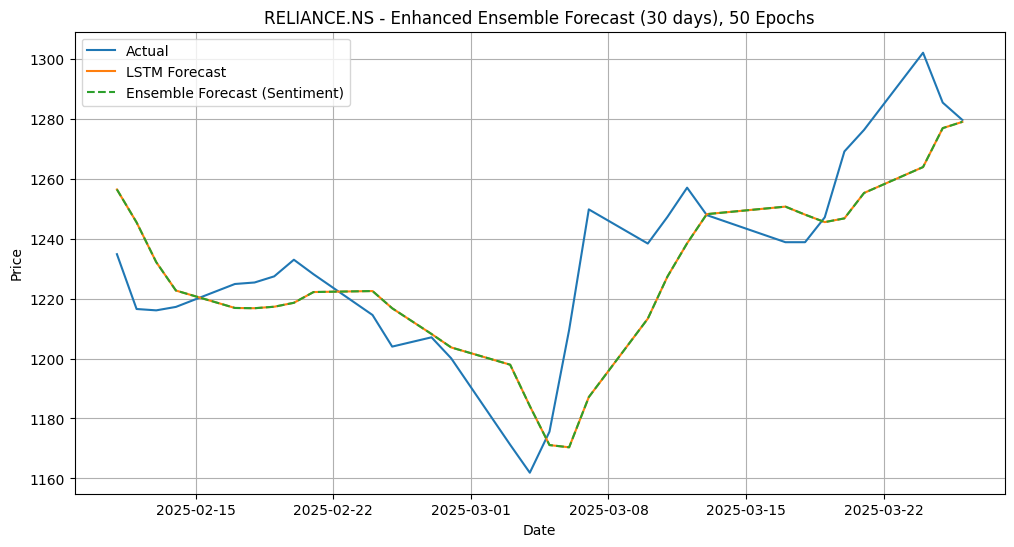

Epoch 1/100


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - loss: 0.0271 - learning_rate: 0.0010
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 5/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 8.2020e-04 - learning_rate: 0.0010
Epoch 6/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 6.9653e-04 - learning_rate: 0.0010
Epoch 7/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 5.8405e-04 - learning_rate: 0.0010
Epoch 8/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 5.9754e-04 - learning_rate: 0.0010
Epoch 9/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 8.1230e-04 - learning_rate: 0.0010
Epoch 10/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 5.7954e-04 - learning_rate: 0.0010
Epoch 11/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 9

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


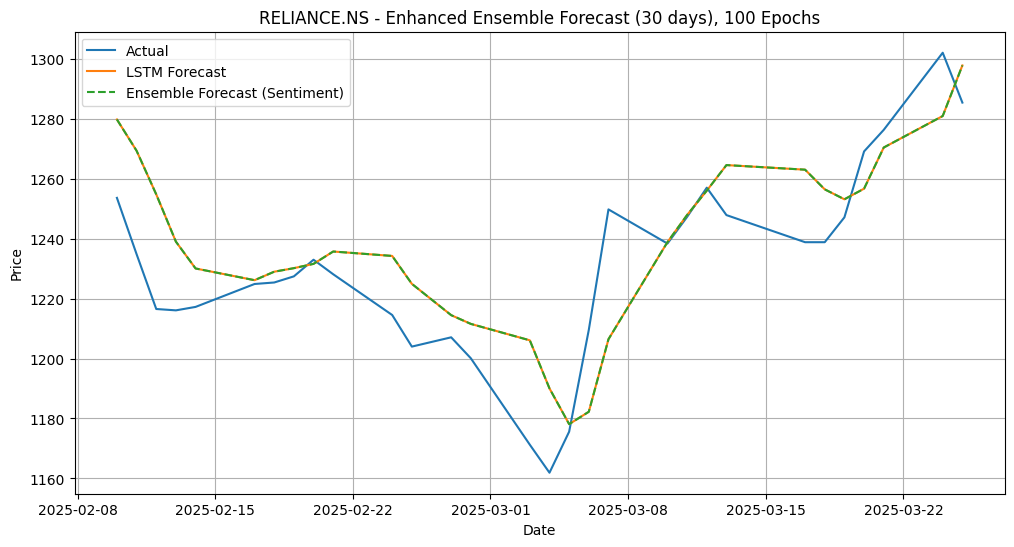

c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - loss: 0.0282 - learning_rate: 0.0010
Epoch 2/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 3/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 4/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 5/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 9.5882e-04 - learning_rate: 0.0010
Epoch 6/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 7.4677e-04 - learning_rate: 0.0010
Epoch 7/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 7.6210e-04 - learning_rate: 0.0010
Epoch 8/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 6.1691e-04 - learning_rate: 0.0010
Epoch 9/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 5.4503e-04 - learning_rate: 0.0010
Epoch 10/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 4.3779e-04 - learning_rate: 0.0010
Epoch 11/150
221/221 ━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


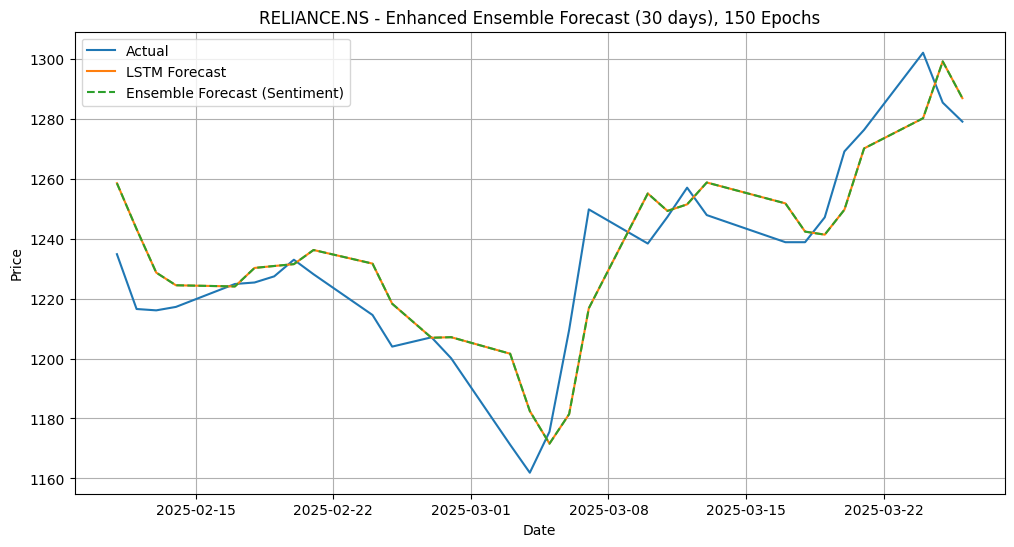

Epoch 1/200


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 0.0291 - learning_rate: 0.0010
Epoch 2/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 3/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 4/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 5/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 6/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 7/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 8.2122e-04 - learning_rate: 0.0010
Epoch 8/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 7.0406e-04 - learning_rate: 0.0010
Epoch 9/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 5.7573e-04 - learning_rate: 0.0010
Epoch 10/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 5.9894e-04 - learning_rate: 0.0010
Epoch 11/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


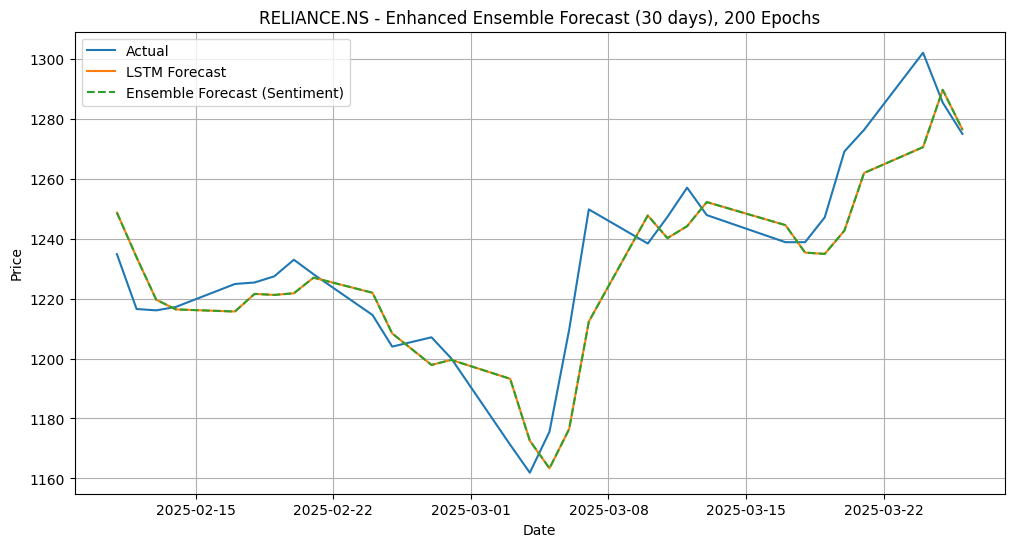

Epoch 1/250


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.0323 - learning_rate: 0.0010
Epoch 2/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 3/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 4/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 5/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 6/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 7/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 9.2493e-04 - learning_rate: 0.0010
Epoch 8/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 8.3549e-04 - learning_rate: 0.0010
Epoch 9/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 7.3607e-04 - learning_rate: 0.0010
Epoch 10/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 8.3995e-04 - learning_rate: 0.0010
Epoch 11/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


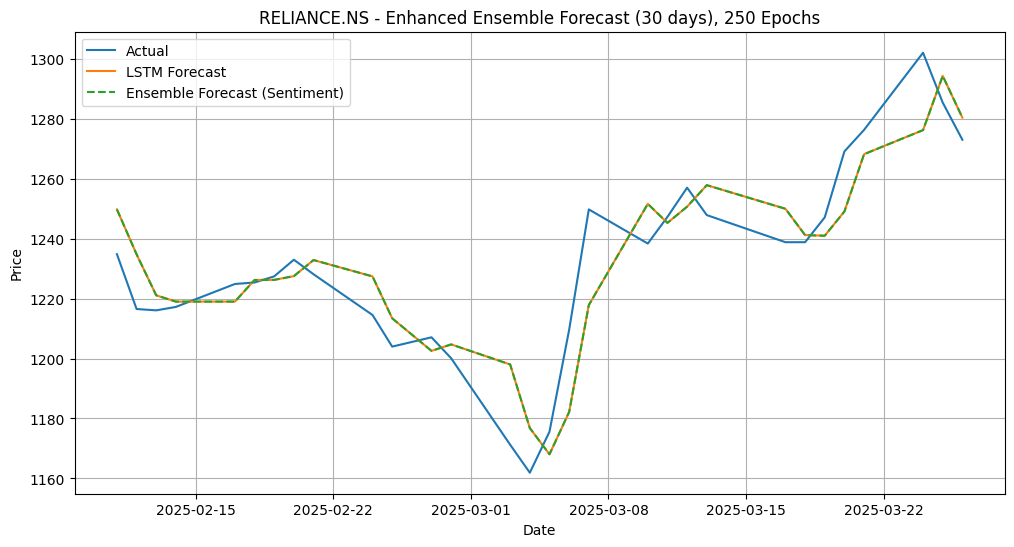

In [ ]:

forecast_ensemble("RELIANCE.NS",epoch=50)
forecast_ensemble("RELIANCE.NS",epoch=100)
forecast_ensemble("RELIANCE.NS",epoch=150)
forecast_ensemble("RELIANCE.NS",epoch=200)
forecast_ensemble("RELIANCE.NS",epoch=250)

Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 0.0432 - learning_rate: 0.0010
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0068 - learning_rate: 0.0010
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0030 - learning_rate: 0.0010
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 9.9480e-04 - learning_rate: 0.0010
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 7.8729e-04 - learning_rate: 0.0010
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 8.5549e-04 - learni

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.0361 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0048 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 8.4232e-04 - learning_rate: 0.0010
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 9.1006e-04 - learning_rate: 0.0010
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 8.2438e-04 - learning_rate: 0.0010
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 6.7381e-04 - learning_rate: 0.0010
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 5.9985e-04 - learning_rate: 0.0010
Epoch 11/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 5.8894e

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.0837 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0071 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0048 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0026 - learning_rate: 0.0010
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 10/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 11/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0011 - learning_rate: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEAUTO']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEIT']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMETAL']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:


⚠️ Warning: No data found for ^NSEAUTO. Skipping...
⚠️ Warning: No data found for ^NSEIT. Skipping...
⚠️ Warning: No data found for ^NSEMETAL. Skipping...


ERROR:yfinance:['^NSEENERGY']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEENERGY. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPHARMA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:


⚠️ Warning: No data found for ^NSEPHARMA. Skipping...


ERROR:yfinance:['^NSEFMCG']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPSU']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEREALTY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEINFRA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSESMALLCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEFMCG. Skipping...
⚠️ Warning: No data found for ^NSEPSU. Skipping...
⚠️ Warning: No data found for ^NSEREALTY. Skipping...
⚠️ Warning: No data found for ^NSEINFRA. Skipping...
⚠️ Warning: No data found for ^NSEMIDCAP. Skipping...
⚠️ Warning: No data found for ^NSESMALLCAP. Skipping...


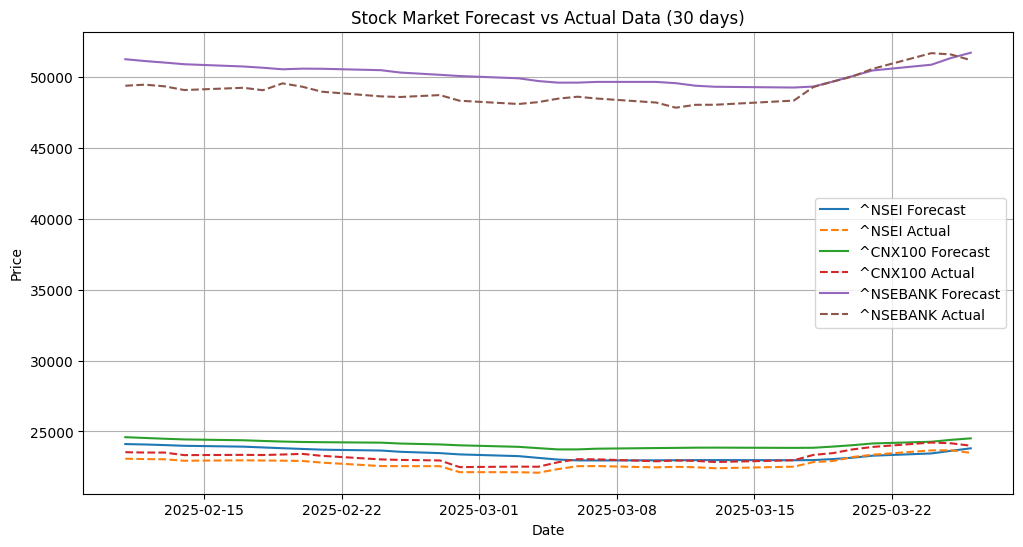

Epoch 1/100


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
nifty_indices = ['^NSEI', '^CNX100', '^NSEBANK', '^NSEAUTO', '^NSEIT', '^NSEMETAL', '^NSEENERGY', '^NSEPHARMA', '^NSEFMCG', '^NSEPSU', '^NSEREALTY', '^NSEINFRA', '^NSEMIDCAP', '^NSESMALLCAP']
forecast_multiple_indices(nifty_indices, epoch=50)
forecast_multiple_indices(nifty_indices, epoch=100)
forecast_multiple_indices(nifty_indices, epoch=150)
forecast_multiple_indices(nifty_indices, epoch=200)
forecast_multiple_indices(nifty_indices, epoch=250)
